# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('~/linearModels//data/airbnb_hw.csv')
data.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [3]:
data.shape

(30478, 13)

In [4]:
data.isnull().sum()

Host Id                          0
Host Since                       3
Name                             0
Neighbourhood                    0
Property Type                    3
Review Scores Rating (bin)    8323
Room Type                        0
Zipcode                        134
Beds                            85
Number of Records                0
Number Of Reviews                0
Price                            0
Review Scores Rating          8323
dtype: int64

In [5]:
data.columns

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')

In [6]:
data['Zipcode'] = data['Zipcode'].apply(lambda x: int(x) if x.is_integer() else x)
data.dropna(inplace=True)
data['Review Scores Rating (bin)'] = data['Review Scores Rating (bin)'].astype(int)
data['Review Scores Rating'] = data['Review Scores Rating'].astype(int)
data['Zipcode'] = data['Zipcode'].astype(int)
data['Price'] = data['Price'].replace(',', '', regex=True)
data['Price'] = data['Price'].astype(int)


In [7]:
data.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95,Private room,10036,3.0,1,39,549,96
5,1039,7/25/2008,Big Greenpoint 1BD w/ Skyline View,Brooklyn,Apartment,100,Entire home/apt,11222,1.0,1,4,149,100
6,1783,8/12/2008,Amazing Also,Manhattan,Apartment,100,Entire home/apt,10004,1.0,1,9,250,100
7,2078,8/15/2008,"Colorful, quiet, & near the subway!",Brooklyn,Apartment,90,Private room,11201,1.0,1,80,90,94
8,2339,8/20/2008,East Village Cocoon: 2 Bedroom Flat,Manhattan,Apartment,90,Entire home/apt,10009,2.0,1,95,270,90


array([[<Axes: title={'center': 'Host Id'}>,
        <Axes: title={'center': 'Review Scores Rating (bin)'}>,
        <Axes: title={'center': 'Zipcode'}>],
       [<Axes: title={'center': 'Beds'}>,
        <Axes: title={'center': 'Number of Records'}>,
        <Axes: title={'center': 'Number Of Reviews'}>],
       [<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Review Scores Rating'}>, <Axes: >]],
      dtype=object)

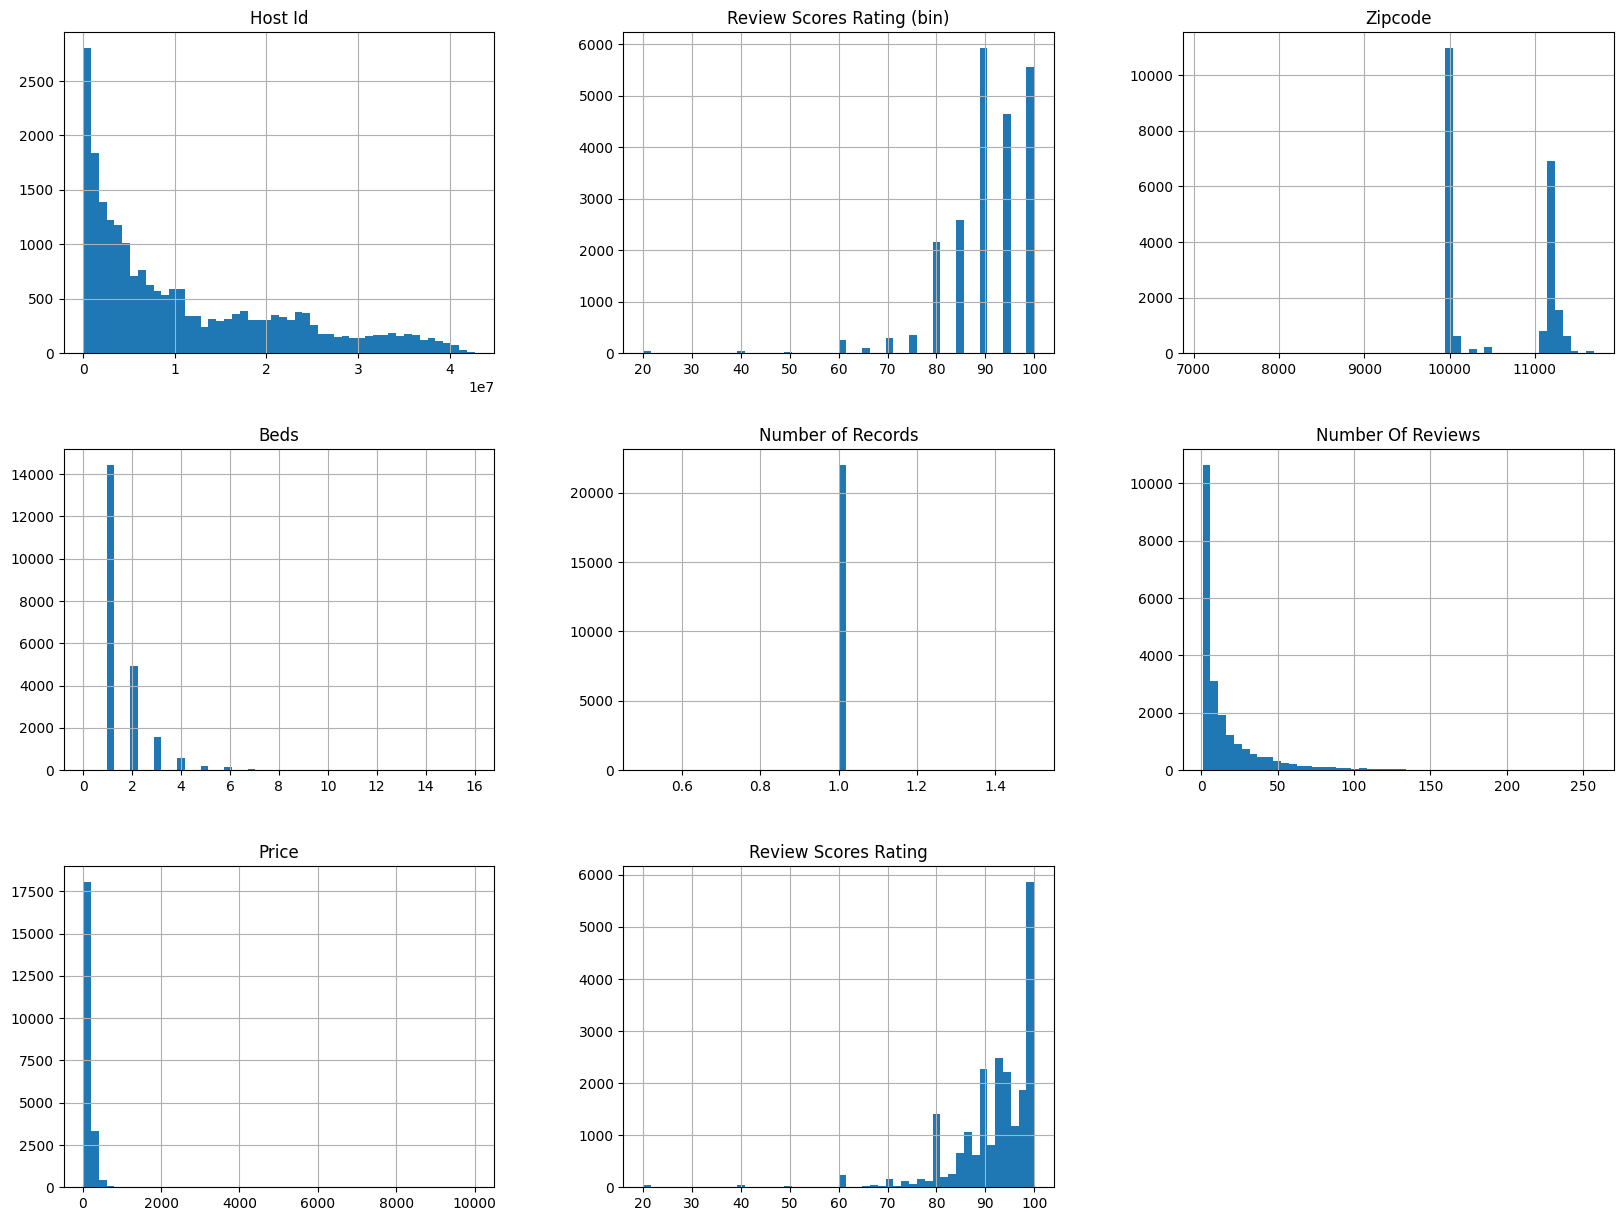

In [8]:
data.hist(bins=50, figsize=(20,15))

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
categorical_cols = data.select_dtypes(include=['object']).columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_data = ohe.fit_transform(data[categorical_cols])
cat_df = pd.DataFrame(cat_data, columns=ohe.get_feature_names_out(categorical_cols))
data.drop(columns=categorical_cols, inplace=True)
df = pd.concat([data, cat_df], axis=1)

In [14]:
from sklearn.model_selection import train_test_split
X = data.drop(columns='Price')
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')


Train RMSE: 136.56214277034502
Test RMSE: 120.61272946318608
Train R^2: 0.18764211934672748
Test R^2: 0.24064317861265438


Neither model seems to fit well but this could be on my part. I'm not sure if I computed the data correctly for the train and test split.

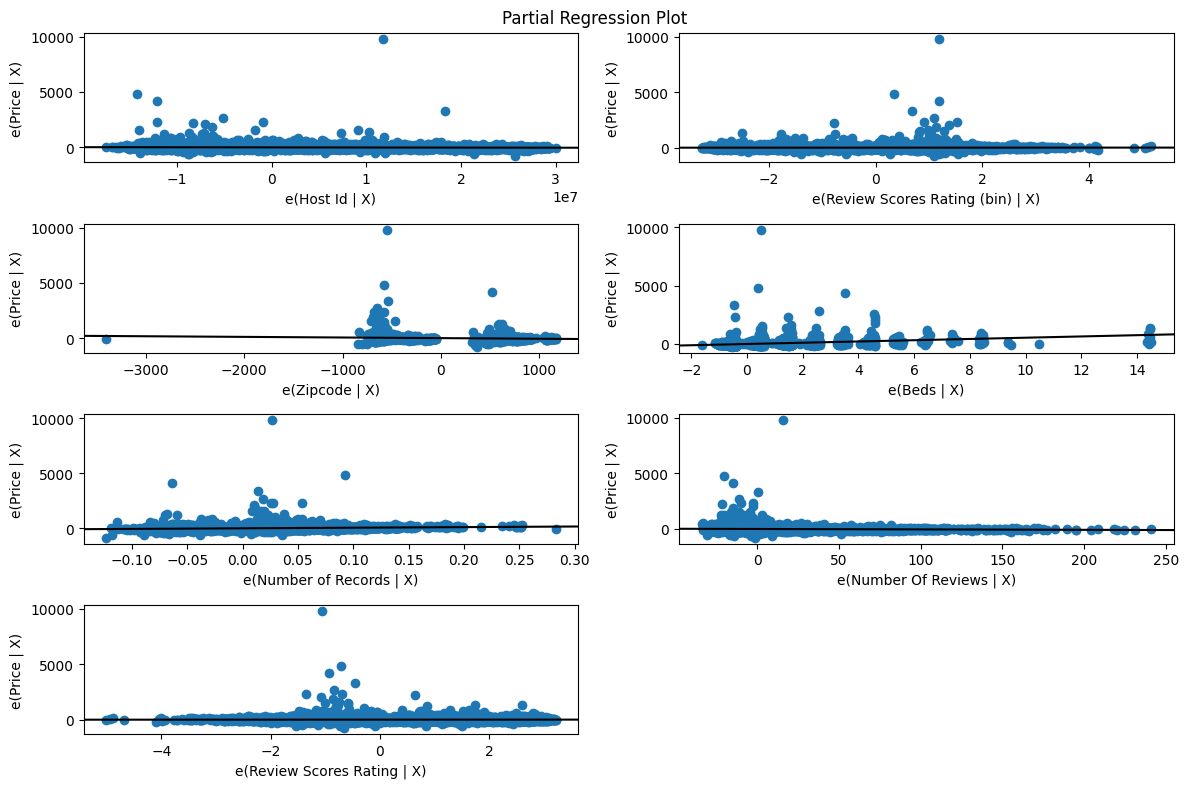

In [19]:
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid

X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()
fig = plt.figure(figsize=(12, 8))
plot_partregress_grid(model, fig=fig)
plt.show()

There seems to be some non-linearities with the beds and also the zipcode. This is probably because the amount of beds falls into a few distinct categories and zipcodes dont vary too much so there wont be a big distribution of them.

In [20]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_train_pred_poly = lr_poly.predict(X_train_poly)
y_test_pred_poly = lr_poly.predict(X_test_poly)

poly_train_rmse= np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
poly_test_rmse= np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
poly_train_r2 = r2_score(y_train, y_train_pred_poly)
poly_test_r2 = r2_score(y_test, y_test_pred_poly)

print(f'Polynomial Train RMSE: {poly_train_rmse}')
print(f'Polynomial Test RMSE: {poly_test_rmse}')
print(f'Polynomial Train R^2: {poly_train_r2}')
print(f'Polynomial Test R^2: {poly_test_r2}')

Polynomial Train RMSE: 135.64799913184527
Polynomial Test RMSE: 124.63336857717658
Polynomial Train R^2: 0.19848152565960842
Polynomial Test R^2: 0.18917286589175797


With my more complex model, the R^2 decreased but again I think it is from issues with my one-hot encoding.

In [21]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_poly, y_train)
y_train_pred_lasso = lasso.predict(X_train_poly)
y_test_pred_lasso = lasso.predict(X_test_poly)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+08, tolerance: 4.042e+04
  model = cd_fast.enet_coordinate_descent(
